## This file tests running a animation within Jupyter


In [13]:
%matplotlib inline

In [14]:
import openseespy.opensees as ops
import openseespy.postprocessing.Get_Rendering as opp
from IPython.display import HTML

ops.wipe()
ops.model("BasicBuilder", "-ndm",3, "-ndf",6)

# set default units
ops.defaultUnits("-force", "kip", "-length", "in", "-time", "sec", "-temp", "F")

# Define the section
# ------------------
#                                       secTag  E     nu     h    rho
ops.section("ElasticMembranePlateSection", 1, 3.0E3, 0.25, 1.175, 1.27)

# Define geometry
# ---------------
# these should both be even

nx = 10
ny = 2

# loaded nodes
mid   = int(((nx+1)*(ny+1) + 1)/2)
side1 = int((nx+2)/2) 
side2 = int((nx+1)*(ny+1) - side1 + 1)

# generate the nodes and elements
#          numX numY startNode startEle eleType eleArgs? coords?
ops.block2D(nx, ny, 1, 1,
            "ShellMITC4", 1,
            1, -20.0,  0.0,  0.0,
            2, -20.0,  0.0, 40.0,
            3,  20.0,  0.0, 40.0,
            4,  20.0,  0.0,  0.0,
            5, -10.0, 10.0, 20.0, 
            7,  10.0, 10.0, 20.0,   
            9,   0.0, 10.0, 20.0)

# define the boundary conditions
ops.fixZ( 0.0, 1, 1, 1, 0, 1, 1)
ops.fixZ(40.0, 1, 1, 1, 0, 1, 1)  

ops.mass(20, 10.0, 10.0, 10.0, 0.0, 0.0, 0.0)

# create a Linear time series
ops.timeSeries("Linear", 1)

# add some loads
ops.pattern("Plain", 1, 1, "-fact", 1.0)
ops.load(mid  , 0.0, -0.50, 0.0, 0.0, 0.0, 0.0)
ops.load(side1, 0.0, -0.25, 0.0, 0.0, 0.0, 0.0)
ops.load(side2, 0.0, -0.25, 0.0, 0.0, 0.0, 0.0)

# ------------------------
# Start of static analysis
# ------------------------
# Load control with variable load steps
#                            init  Jd  min  max
ops.integrator("LoadControl", 1.0, 1, 1.0, 10.0)
ops.test("EnergyIncr", 1.0E-10, 20, 0)
ops.algorithm("Newton")
ops.numberer("RCM")
ops.constraints("Plain") 
ops.system("SparseGeneral", "-piv")
ops.analysis("Static") 
ops.analyze(5)

# ---------------------------------------
# Create and Perform the dynamic analysis
# ---------------------------------------
# Remove the static analysis & reset the time to 0.0

ops.wipeAnalysis()
ops.setTime(0.0)

# Now remove the loads and let the beam vibrate
ops.remove("loadPattern", 1)



Model = '3D_Shell'
LoadCase = 'Transient'
LoadCase2 = 'Transient_5s'
opp.createODB(Model, LoadCase, Nmodes = 3, recorders = [])
opp.createODB(Model, LoadCase2, Nmodes = 3, deltaT = 5., recorders = [])


# Create the transient analysis
ops.test("EnergyIncr", 1.0E-10, 20, 0)
ops.algorithm("Newton")
ops.numberer("RCM")
ops.constraints("Plain") 
ops.system("SparseGeneral", "-piv")
ops.integrator("Newmark", 0.50, 0.25)
ops.analysis("Transient")





# Perform the transient analysis (20 sec)
ops.analyze(100, 0.2)
ops.wipe()
####### Model Visualization


dt = 0.2


[[22.48936871  8.53949876  7.50765138]] [0.07805580502936654, 0.541370985938891, 0.7004087138451218, 1.077041290916772]
[[22.48936871  8.53949876  7.50765138]] [0.07805580502936657, 0.5413709859388914, 0.7004087138451212, 1.0770412909167713]


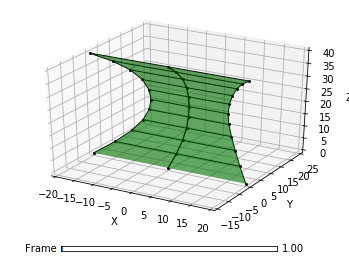

In [15]:
ani = opp.animate_deformedshape( Model, LoadCase, dt, Scale=30)
HTML(ani.to_html5_video())